In [1]:
import numpy as np
# np.random.seed(42)
import pandas as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import sys
import heapq
import seaborn as sns
import matplotlib
from numpy.core.multiarray import dtype
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop
from pylab import rcParams
matplotlib.use('agg')

In [3]:
import pandas as pd
gmo_csv = pd.read_csv('data-setup/GMO.csv')
gmo_csv

,Unnamed: 0,user_name,user_location,user_description,user_verified,date,text,hashtags,source
0,0,Divinity Seven♻️🏥,"Las Vegas, NV","UNLV BS Public Administration, M.Ed, USC MSW, ...",False,2022-08-08 22:40:57+00:00,RT @FDAfood: Consumers and healthcare professi...,"['GMOs', 'FeedYourMind']",Twitter for iPhone
1,1,Marco Pino,Panamá,"Promovamos valores en nuestra sociedad, paz y ...",False,2022-08-08 19:36:54+00:00,RT @FDAfood: Consumers and healthcare professi...,"['GMOs', 'FeedYourMind']",Twitter for Android
2,2,FDA_ORA,NaN,Get the latest information from FDA’s Office o...,True,2022-08-08 19:30:12+00:00,RT @FDAfood: Consumers and healthcare professi...,"['GMOs', 'FeedYourMind']",Twitter for iPhone
3,3,FDA FOOD (Ctr for Food Safety & Applied Nutrit...,"College Park, MD","The latest on food safety, outbreaks, recalls,...",True,2022-08-08 18:51:00+00:00,Consumers and healthcare professionals can now...,"['GMOs', 'FeedYourMind']",Twitter Web App
4,4,Dirt To Dinner,"Connecticut, USA",Providing you with a better understanding of f...,False,2022-08-08 18:45:01+00:00,The message from the mainstream scientific and...,"['CRISPR', 'GMOs']",Sprout Social
...,...,...,...,...,...,...,...,...,...
400,400,sse.ndi,NaN,discombobulated fr,False,2022-08-04 12:40:40+00:00,RT @UgandaBIC: Wheat is 1 of the most importan...,NaN,Twitter for iPhone
401,401,Godfrey Asea,Namulonge,My heart is in crops research for development!,False,2022-08-04 12:39:59+00:00,RT @UgandaBIC: Wheat is 1 of the most importan...,NaN,Twitter for iPhone
402,402,NARO-NaCRRI-Namulonge,"27km, Gayaza-Zirobwe road",Uganda's premier crops resources research & de...,False,2022-08-04 12:39:14+00:00,RT @UgandaBIC: Wheat is 1 of the most importan...,NaN,Twitter for iPhone
403,403,UBIC,NaCRRI-Namulonge,Uganda's premier modern Ag-biosciences informa...,False,2022-08-04 12:36:48+00:00,Wheat is 1 of the most important food crops wo...,NaN,Twitter for iPhone


In [4]:
words = ' '.join(text for text in gmo_csv['text'])
text = words.lower()

In [5]:
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
print ("unique chars: ",len(chars))

unique chars:  89


In [6]:
SEQUENCE_LENGTH = 39
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i:i+SEQUENCE_LENGTH])
    next_chars.append(text[i+SEQUENCE_LENGTH])
print ('num training examples: ',len(sentences))

num training examples:  20207


In [7]:
import numpy as np
X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

/var/folders/4m/jxk5_ydd4zl7c_t8ktc70vnw0000gn/T/ipykernel_21912/3626284764.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
/var/folders/4m/jxk5_ydd4zl7c_t8ktc70vnw0000gn/T/ipykernel_21912/3626284764.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.zeros((len(s

In [8]:
model = Sequential();
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

2022-09-05 00:42:07.013663: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
optimizer = RMSprop(lr= 0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


150/150 [==============================] - 19s 106ms/step - loss: 2.7594 - accuracy: 0.2670 - val_loss: 2.7555 - val_accuracy: 0.2552
Epoch 2/20
150/150 [==============================] - 14s 91ms/step - loss: 1.7771 - accuracy: 0.5306 - val_loss: 2.5684 - val_accuracy: 0.3254
Epoch 3/20
150/150 [==============================] - 13s 83ms/step - loss: 1.2787 - accuracy: 0.6658 - val_loss: 2.4565 - val_accuracy: 0.3670
Epoch 4/20
150/150 [==============================] - 12s 77ms/step - loss: 1.0033 - accuracy: 0.7362 - val_loss: 2.3593 - val_accuracy: 0.3877
Epoch 5/20
150/150 [==============================] - 16s 108ms/step - loss: 0.8335 - accuracy: 0.7817 - val_loss: 2.3734 - val_accuracy: 0.4055
Epoch 6/20
150/150 [==============================] - 17s 115ms/step - loss: 0.7096 - accuracy: 0.8103 - val_loss: 2.3163 - val_accuracy: 0.4243
Epoch 7/20
 33/150 [=====>........................] - ETA: 14s - loss: 0.5841 - accuracy: 0.8442

KeyboardInterrupt: 

In [92]:
model.save('keras_model'+str(SEQUENCE_LENGTH)+'.h5')
pickle.dump(history, open('history'+str(SEQUENCE_LENGTH)+'.p', 'wb'))
model.predict_step

In [93]:
model = load_model('keras_model'+str(SEQUENCE_LENGTH)+'.h5')
history = pickle.load(open('history'+str(SEQUENCE_LENGTH)+'.p', 'rb'))

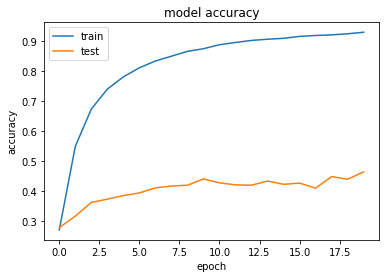

In [94]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc= 'upper left')
plt.savefig("01.Accuracy.png")

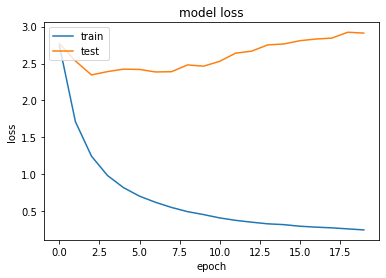

In [95]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc= 'upper left')
plt.savefig("02.Loss.png")

In [10]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1
    return x

In [11]:
def sample(preds, top_n = 3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [12]:
def predict_completion(text):
    original_text = text
    generalised = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [13]:
def predict_completions(text, n = 3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [14]:
str(gmo_csv['text'][60])

'RT @nongmoreport: This page contains a lot of good information on what #nonGMO means, what #GMOs are, why GMOs pose threats to human health…'

In [15]:
quotes = [
    str(gmo_csv['text'][60]),
    str(gmo_csv['text'][70]),
    str(gmo_csv['text'][80]),
    str(gmo_csv['text'][90]),
    str(gmo_csv['text'][100]),
    "GMOs are very unsafe today"
]

In [16]:
for q in quotes:
    seq = q[:SEQUENCE_LENGTH].lower()
    print (seq)
    print (predict_completions(seq, 5))
    print ()

rt @nongmoreport: this page contains a 
['lou ', 'rom ', 'mout ', 'pormaculture ', 'hom ']

the nsa are robbing patriots with mossa
['t ', 'nd ', 'rt ', 'ld ', ': ']

rt @drvandanashiva: nature’s food econo
['my ', 'by ', ' y ', 'gy ', 'ty ']

rt @drvandanashiva: nature’s food econo
['my ', 'by ', ' y ', 'gy ', 'ty ']

rt @organiclivefood: only in us #organi
['c ', 'on ', 's ', 'n ', 'bifermand ']

gmos are very unsafe today
['  ', 't ', 'e ', 'n ', 'r ']



In [17]:
import tensorflow as tf
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.optimizers import Adam
import numpy as np

In [18]:
tokenizer = Tokenizer()
corpus = text.lower().split("\n")
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1
print(tokenizer.word_index)
print(total_words)
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

{'rt': 1, 'gmos': 2, 'the': 3, 'of': 4, 'food': 5, 'in': 6, 'co': 7, 't': 8, 'https': 9, 'are': 10, 'to': 11, 'us': 12, 'that': 13, 'not': 14, 'grown': 15, 'we': 16, 'organiclivefood': 17, '…': 18, 'only': 19, 'no': 20, 'farmers': 21, 'be': 22, 'do': 23, 'organic': 24, 'bayer': 25, 'monsanto': 26, 'like': 27, 'treated': 28, 'terrorists': 29, 'shall': 30, 'own': 31, 'is': 32, 'and': 33, 'gmwatch': 34, 'a': 35, 'for': 36, 'new': 37, 'amp': 38, 'industrial': 39, 'how': 40, 'drvandanashiva': 41, 'by': 42, 'as': 43, 'have': 44, 'plants': 45, 'green': 46, 'products': 47, 'economy': 48, 'plantbased': 49, 'life': 50, 'deregulation': 51, 'nature’s': 52, 'since': 53, 'all': 54, 'sustained': 55, 'leaves': 56, 'fakefood': 57, 'toxic': 58, 'countries': 59, 'with': 60, 'economy…': 61, 'on': 62, 'our': 63, 'other': 64, 'fields': 65, 'it': 66, '2': 67, 'feeding': 68, 'than': 69, 'through': 70, 'about': 71, 'corn': 72, 'breeding': 73, 'a…': 74, 'truss': 75, 'world': 76, 'vows': 77, '‘unleash': 78, 'bri

In [19]:
# pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [20]:
# create predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [21]:
#Model build
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(xs, ys, epochs=100, verbose=1)
#print model.summary()
print(model)

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


  4/293 [..............................] - ETA: 8:37 - loss: 6.8526 - accuracy: 0.0234    

KeyboardInterrupt: 

In [ ]:
seed_text = "GMOs are"
next_words = 10
#Prediction
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
seed_text += " " + output_word
print(seed_text)